# PLINDER validation set

In [1]:
import os

import plinder.core.utils.config

cfg = plinder.core.get_config()

# print(f"local cache directory: {cfg.data.plinder_dir}")
print(f"remote data directory: {cfg.data.plinder_remote}")  # noqa: T201

remote data directory: gs://plinder/2024-06/v2


Use PLINDER package to access the index file. Here is the code how we get `plinder_val_systems.csv` and `plinder_test_systems.csv`.  

### Save the DataFrame to a CSV file
For validation set:

In [ ]:
# from plinder.core.scores import query_index

# # Get system_id, entry_pdb_id, and split columns of train and val splits
# df_val = query_index(
#     columns=[
#         "system_id",
#         "entry_pdb_id",
#         "system_num_ligand_chains",
#         "system_num_protein_chains",
#         "ligand_instance_chain",
#     ],
#     splits=["val"],
# )

# df_val.to_csv("plinder_val_systems.csv", index=False)

For testing set:

In [ ]:
# from plinder.core.scores import query_index

# # Get system_id, entry_pdb_id, and split columns of train and val splits
# df_test = query_index(
#     columns=[
#         "system_id",
#         "entry_pdb_id",
#         "system_num_ligand_chains",
#         "system_num_protein_chains",
#         "ligand_instance_chain",
#     ],
#     splits = ["test"],
# )

# df_test.to_csv("plinder_test_systems.csv", index=False)

In this notebook, we have prepared the index file for the validation set.

In [3]:
import pandas as pd

# Load index of validation systems
df_index = pd.read_csv("./data/plinder_val_systems.csv")

In [4]:
df_index.__len__()

1157

# Protonation

* (run this in a script, not in a notebook)
* (check `plinder_dataset_protonate.py`)

```python
import pandas as pd

from tqdm import tqdm
from protonate import plinder_system_protonate

df = pd.read_csv(
    "./data/plinder_val_systems.csv" # modify the file path here
    )

# each_system_id = df.iloc[0]['system_id']  # Example to access system_id
for each_system_id in tqdm(df['system_id'].unique()):

    # Protonate system for each system_id
    plinder_system_protonate(plinder_system_id=each_system_id)
    
```

# HBond validation

In [5]:
from prolif.io.protein_helper import ProteinHelper

protein_helper = ProteinHelper(
    [
        {
            "MSE": {"SMILES": "C[Se]CC[CH](N)C=O"},
            "SNN": {"SMILES": "O=CC(N)CC(=O)"},
            "OAS": {"SMILES": "CC(=O)C[C@@H](C(=O)O)N"},
        }
    ]
)

/home/yuyang/Project_local/GSoC2025_Hbond_PM/.venv/lib/python3.11/site-packages/MDAnalysis/topology/tables.py:52: DeprecationWarning: Deprecated in version 2.8.0
MDAnalysis.topology.tables has been moved to MDAnalysis.guesser.tables. This import point will be removed in MDAnalysis version 3.0.0
  warnings.warn(wmsg, category=DeprecationWarning)


## Batch analysis (need to prepare data and compute the fingerprints in advance)

In [7]:
import warnings

import prolif as plf
from tqdm import tqdm

warnings.filterwarnings("ignore")


dfs = []
fps = []
dfs_i = []
fps_i = []


for idx in tqdm(df_index.index):
    # Load explicit fingerprint
    if not os.path.exists(f"./val/explicit/fp_{idx}.pkl"):  # noqa: PTH110
        print(f"Explicit fingerprint for index {idx} not found, skipping.")  # noqa: T201
        continue
    if not os.path.exists(  # noqa: PTH110
        f"./val/implicit_old_vina_hbond_potential/fp_{idx}.pkl"
    ):
        print(f"Implicit fingerprint for index {idx} not found, skipping.")  # noqa: T201
        continue
    fp = plf.Fingerprint.from_pickle(f"./val/explicit/fp_{idx}.pkl")
    df = fp.to_dataframe().T
    dfs.append(df)
    fps.append(fp)

    # Load implicit fingerprint
    fp = plf.Fingerprint.from_pickle(
        f"./val/implicit_old_vina_hbond_potential/fp_{idx}.pkl"
    )
    df = fp.to_dataframe().T
    dfs_i.append(df)
    fps_i.append(fp)

    if idx == 2000:
        break

  7%|▋         | 84/1157 [00:00<00:03, 275.07it/s]

Implicit fingerprint for index 44 not found, skipping.


 13%|█▎        | 147/1157 [00:00<00:03, 278.23it/s]

Explicit fingerprint for index 114 not found, skipping.
Explicit fingerprint for index 147 not found, skipping.


 43%|████▎     | 494/1157 [00:01<00:02, 285.67it/s]

Explicit fingerprint for index 440 not found, skipping.


 49%|████▊     | 562/1157 [00:02<00:01, 298.98it/s]

Explicit fingerprint for index 512 not found, skipping.
Explicit fingerprint for index 513 not found, skipping.


 62%|██████▏   | 723/1157 [00:02<00:01, 253.09it/s]

Implicit fingerprint for index 672 not found, skipping.


 74%|███████▎  | 852/1157 [00:03<00:01, 295.39it/s]

Explicit fingerprint for index 817 not found, skipping.


 82%|████████▏ | 950/1157 [00:03<00:00, 306.36it/s]

Implicit fingerprint for index 904 not found, skipping.


 94%|█████████▎| 1084/1157 [00:04<00:00, 217.10it/s]

Explicit fingerprint for index 1049 not found, skipping.
Explicit fingerprint for index 1050 not found, skipping.
Implicit fingerprint for index 1072 not found, skipping.
Implicit fingerprint for index 1075 not found, skipping.
Implicit fingerprint for index 1078 not found, skipping.


100%|██████████| 1157/1157 [00:04<00:00, 263.26it/s]


In [8]:
len(dfs)

1143

In [9]:
import numpy as np
from utils.metrics import (
    get_interactions,
    positive_predictive_value,
    sensitivity,
    tanimoto_coefficient,
)
from utils.postprocess import get_metadata_from_implicit_hbond_using_set

# idx = 5
all_aaa_dev_list = []
all_daa_dev_list = []
all_dpa_list = []
all_apa_list = []
all_vhp_list = []

all_fp_aaa_dev_list = []
all_fp_daa_dev_list = []
all_fp_dpa_list = []
all_fp_apa_list = []
all_fp_avp_list = []
all_fp_vhp_list = []


tm_coefs = []
ppvs = []
sensitivities = []

for idx in range(len(dfs_i)):
    # Get the explicit interaction's implicit metadata
    explicit_set = get_interactions(dfs[idx])

    aaa_dev_list, daa_dev_list, dpa_list, apa_list, vina_hbond_potential_list = (
        get_metadata_from_implicit_hbond_using_set(explicit_set, fps_i[idx])
    )
    all_aaa_dev_list.extend(aaa_dev_list)
    all_daa_dev_list.extend(daa_dev_list)
    all_dpa_list.extend(dpa_list)
    all_apa_list.extend(apa_list)
    all_vhp_list.extend(vina_hbond_potential_list)

    # Get the false positive interaction's implicit metadata
    implicit_set = get_interactions(dfs_i[idx])
    false_positive_set = implicit_set - explicit_set
    false_negative_set = explicit_set - implicit_set
    fp_aaa_dev_list, fp_daa_dev_list, fp_dpa_list, fp_apa_list, fp_vhp_list = (
        get_metadata_from_implicit_hbond_using_set(false_positive_set, fps_i[idx])
    )
    all_fp_aaa_dev_list.extend(fp_aaa_dev_list)
    all_fp_daa_dev_list.extend(fp_daa_dev_list)
    all_fp_dpa_list.extend(fp_dpa_list)
    all_fp_apa_list.extend(fp_apa_list)
    all_fp_vhp_list.extend(fp_vhp_list)

    # Calculate Tanimoto coefficient
    tm_coef = tanimoto_coefficient(explicit_set, implicit_set)
    tm_coefs.append(tm_coef)
    ppv = positive_predictive_value(explicit_set, implicit_set)
    ppvs.append(ppv)
    sens = sensitivity(explicit_set, implicit_set)
    sensitivities.append(sens)

print("Tanimoto coefficients:", np.mean(tm_coefs))  # noqa: T201
print("Positive Predictive Values:", np.mean(ppvs))  # noqa: T201
print("Sensitivities:", np.mean(sensitivities))  # noqa: T201

Tanimoto coefficients: 0.5651308649123679
Positive Predictive Values: 0.5651645145523169
Sensitivities: 0.9985418489355496


In [10]:
# dfs[1], dfs_i[1]

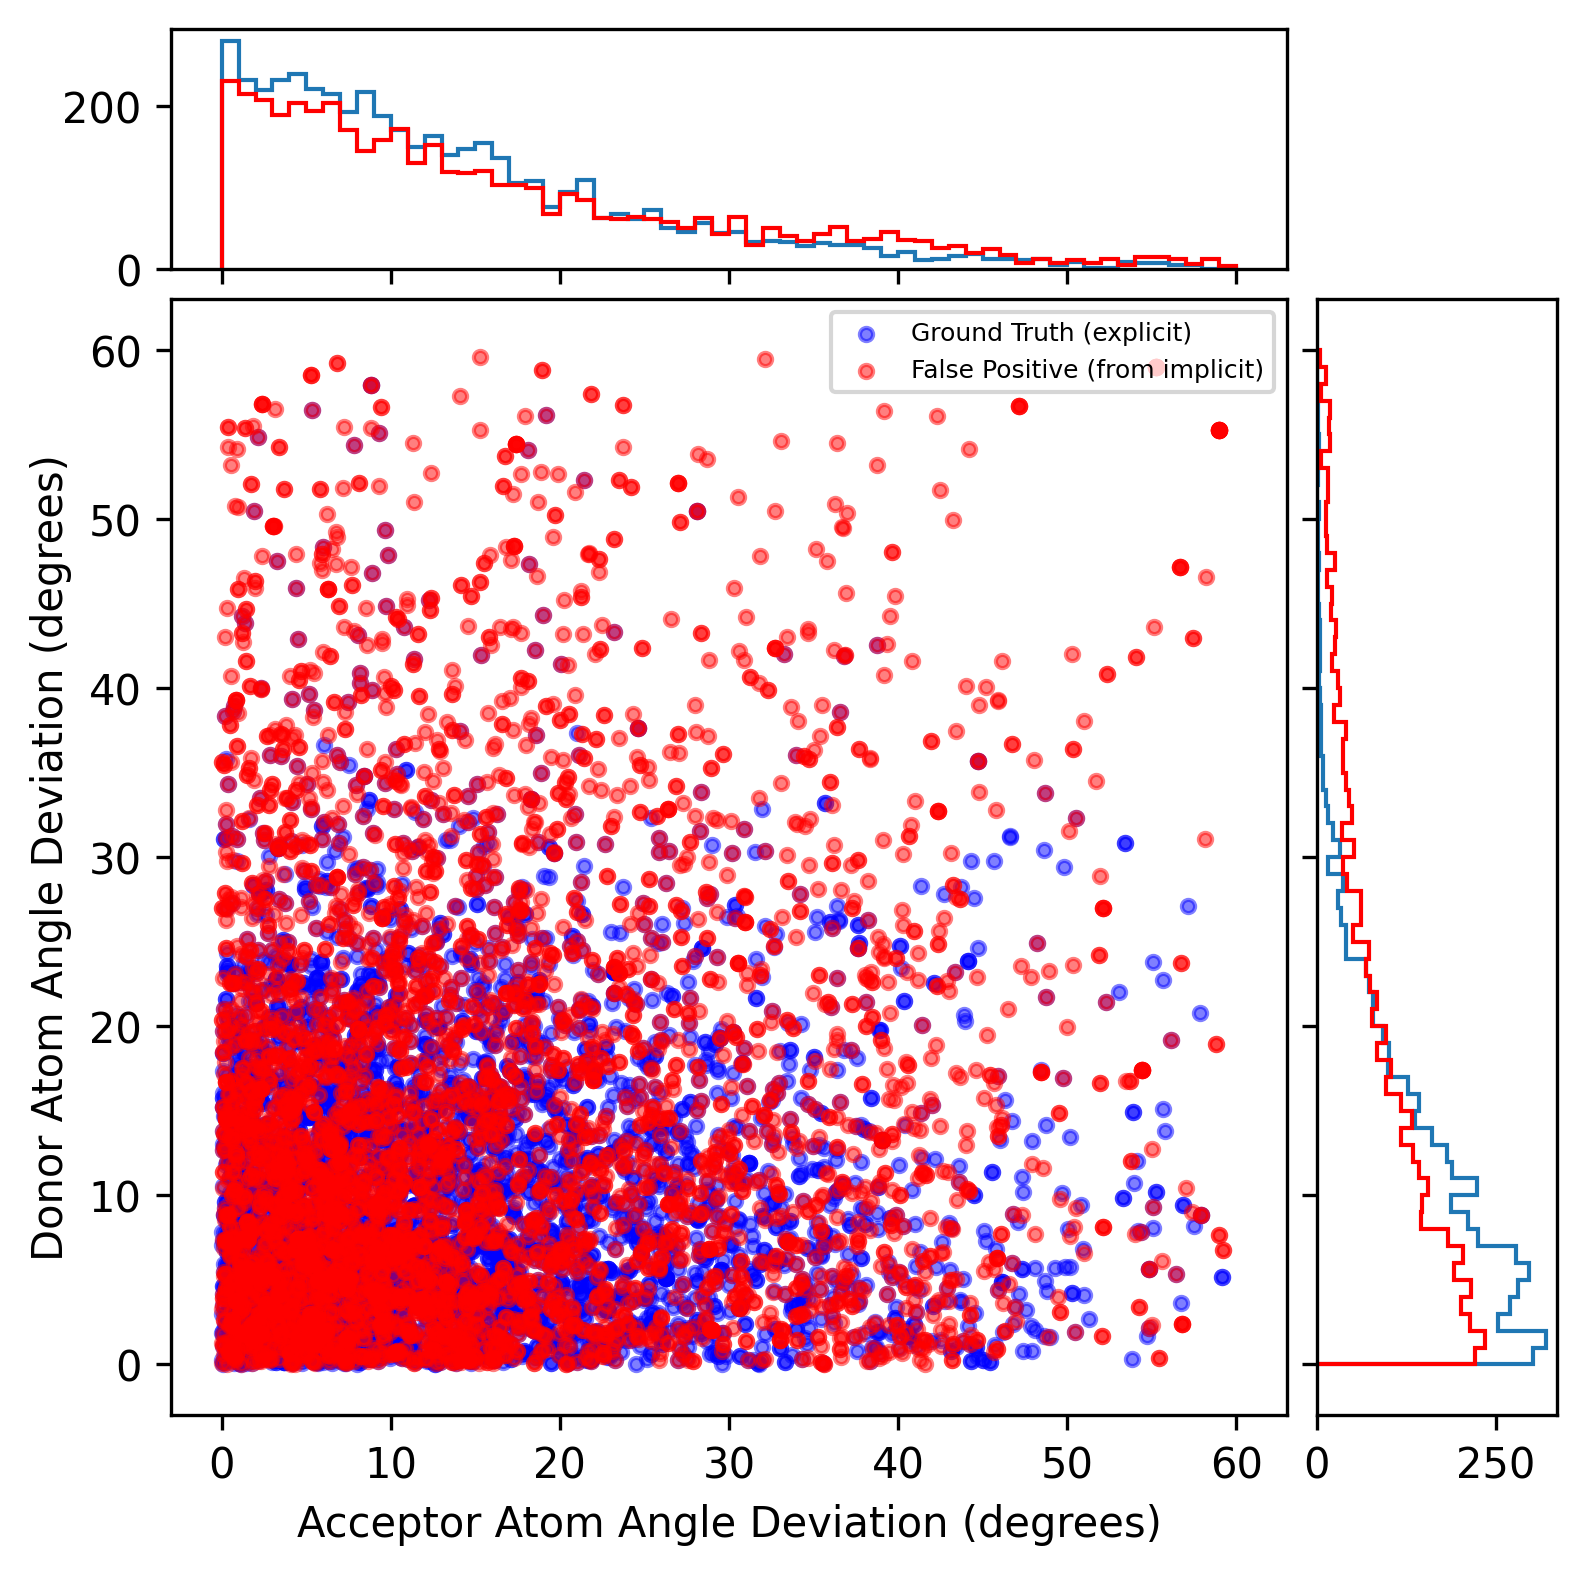

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(dpi=300, figsize=(8, 6))
ax.scatter(all_aaa_dev_list, all_daa_dev_list, s=10, alpha=0.5, c="blue")
ax.scatter(all_fp_aaa_dev_list, all_fp_daa_dev_list, s=10, alpha=0.5, c="red")


# the scatter plot:
# Set aspect of the main Axes.
ax.set_aspect(1.0)

# create new Axes on the right and on the top of the current Axes
divider = make_axes_locatable(ax)
# below height and pad are in inches
ax_histx = divider.append_axes("top", 0.8, pad=0.1, sharex=ax)
ax_histy = divider.append_axes("right", 0.8, pad=0.1, sharey=ax)

# make some labels invisible
ax_histx.xaxis.set_tick_params(labelbottom=False)
ax_histy.yaxis.set_tick_params(labelleft=False)

# now determine nice limits by hand:
binwidth = 1
xymax = max(np.max(np.abs(all_aaa_dev_list)), np.max(np.abs(all_daa_dev_list)))
lim = (int(xymax / binwidth) + 1) * binwidth

bins = np.arange(0, lim + binwidth, binwidth)
ax_histx.hist(all_aaa_dev_list, bins=bins, histtype="step")
ax_histx.hist(all_fp_aaa_dev_list, bins=bins, histtype="step", color="red")
ax_histy.hist(all_daa_dev_list, bins=bins, histtype="step", orientation="horizontal")
ax_histy.hist(
    all_fp_daa_dev_list,
    bins=bins,
    orientation="horizontal",
    histtype="step",
    color="red",
)

# the xaxis of ax_histx and yaxis of ax_histy are shared with ax,
# thus there is no need to manually adjust the xlim and ylim of these
# axis.

# ax_histx.set_yticks([0, 50, 100])
# ax_histy.set_xticks([0, 50, 100])

ax.set_xlabel("Acceptor Atom Angle Deviation (degrees)")
ax.set_ylabel("Donor Atom Angle Deviation (degrees)")
ax.legend(
    ["Ground Truth (explicit)", "False Positive (from implicit)"],
    loc="upper right",
    fontsize=6,
)
fig.show()

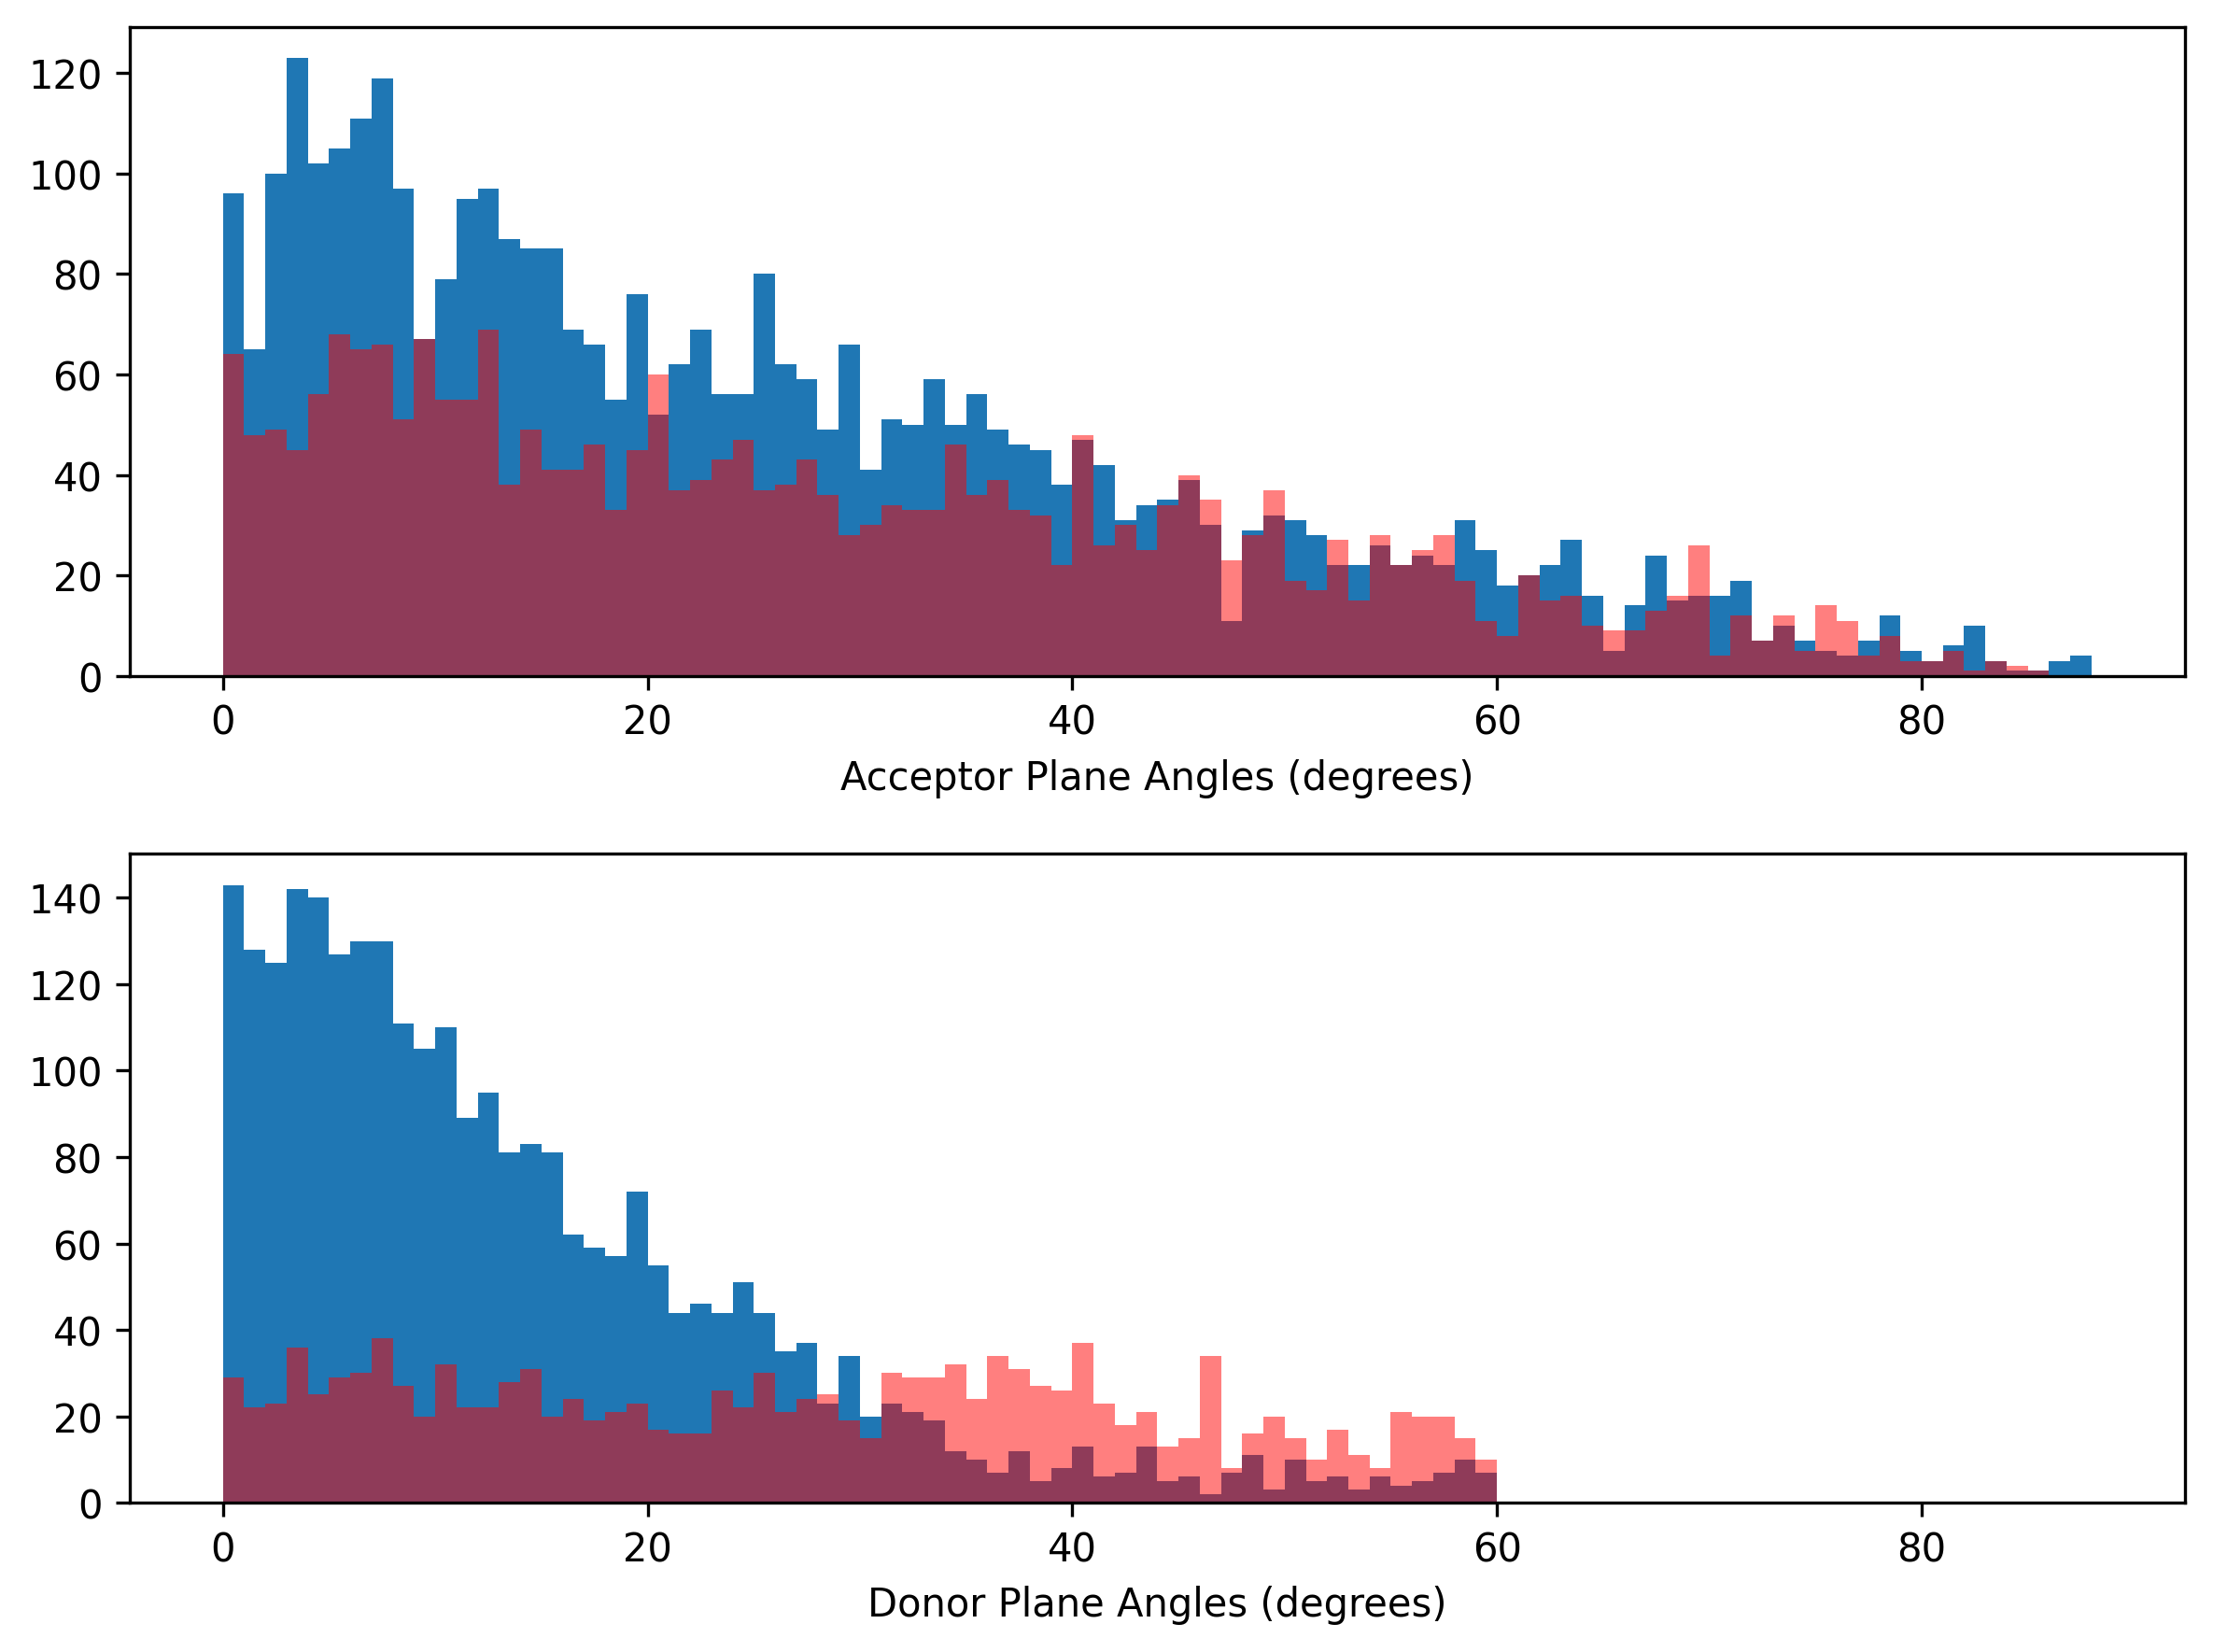

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(2, 1, dpi=300, figsize=(8, 6))

# now determine nice limits by hand:
binwidth = 1
xymax = max(
    np.max(np.abs(all_apa_list)),
    np.max(np.abs(all_dpa_list)),
    np.max(np.abs(all_fp_apa_list)),
    np.max(np.abs(all_fp_dpa_list)),
)
lim = (int(xymax / binwidth) + 1) * binwidth

bins = np.arange(0, lim + binwidth, binwidth)
ax[0].hist(all_apa_list, bins=bins)
ax[0].hist(all_fp_apa_list, bins=bins, alpha=0.5, color="red")
ax[1].hist(all_dpa_list, bins=bins)
ax[1].hist(all_fp_dpa_list, bins=bins, alpha=0.5, color="red")

ax[0].set_xlabel("Acceptor Plane Angles (degrees)")
ax[1].set_xlabel("Donor Plane Angles (degrees)")
fig.tight_layout()
fig.show()

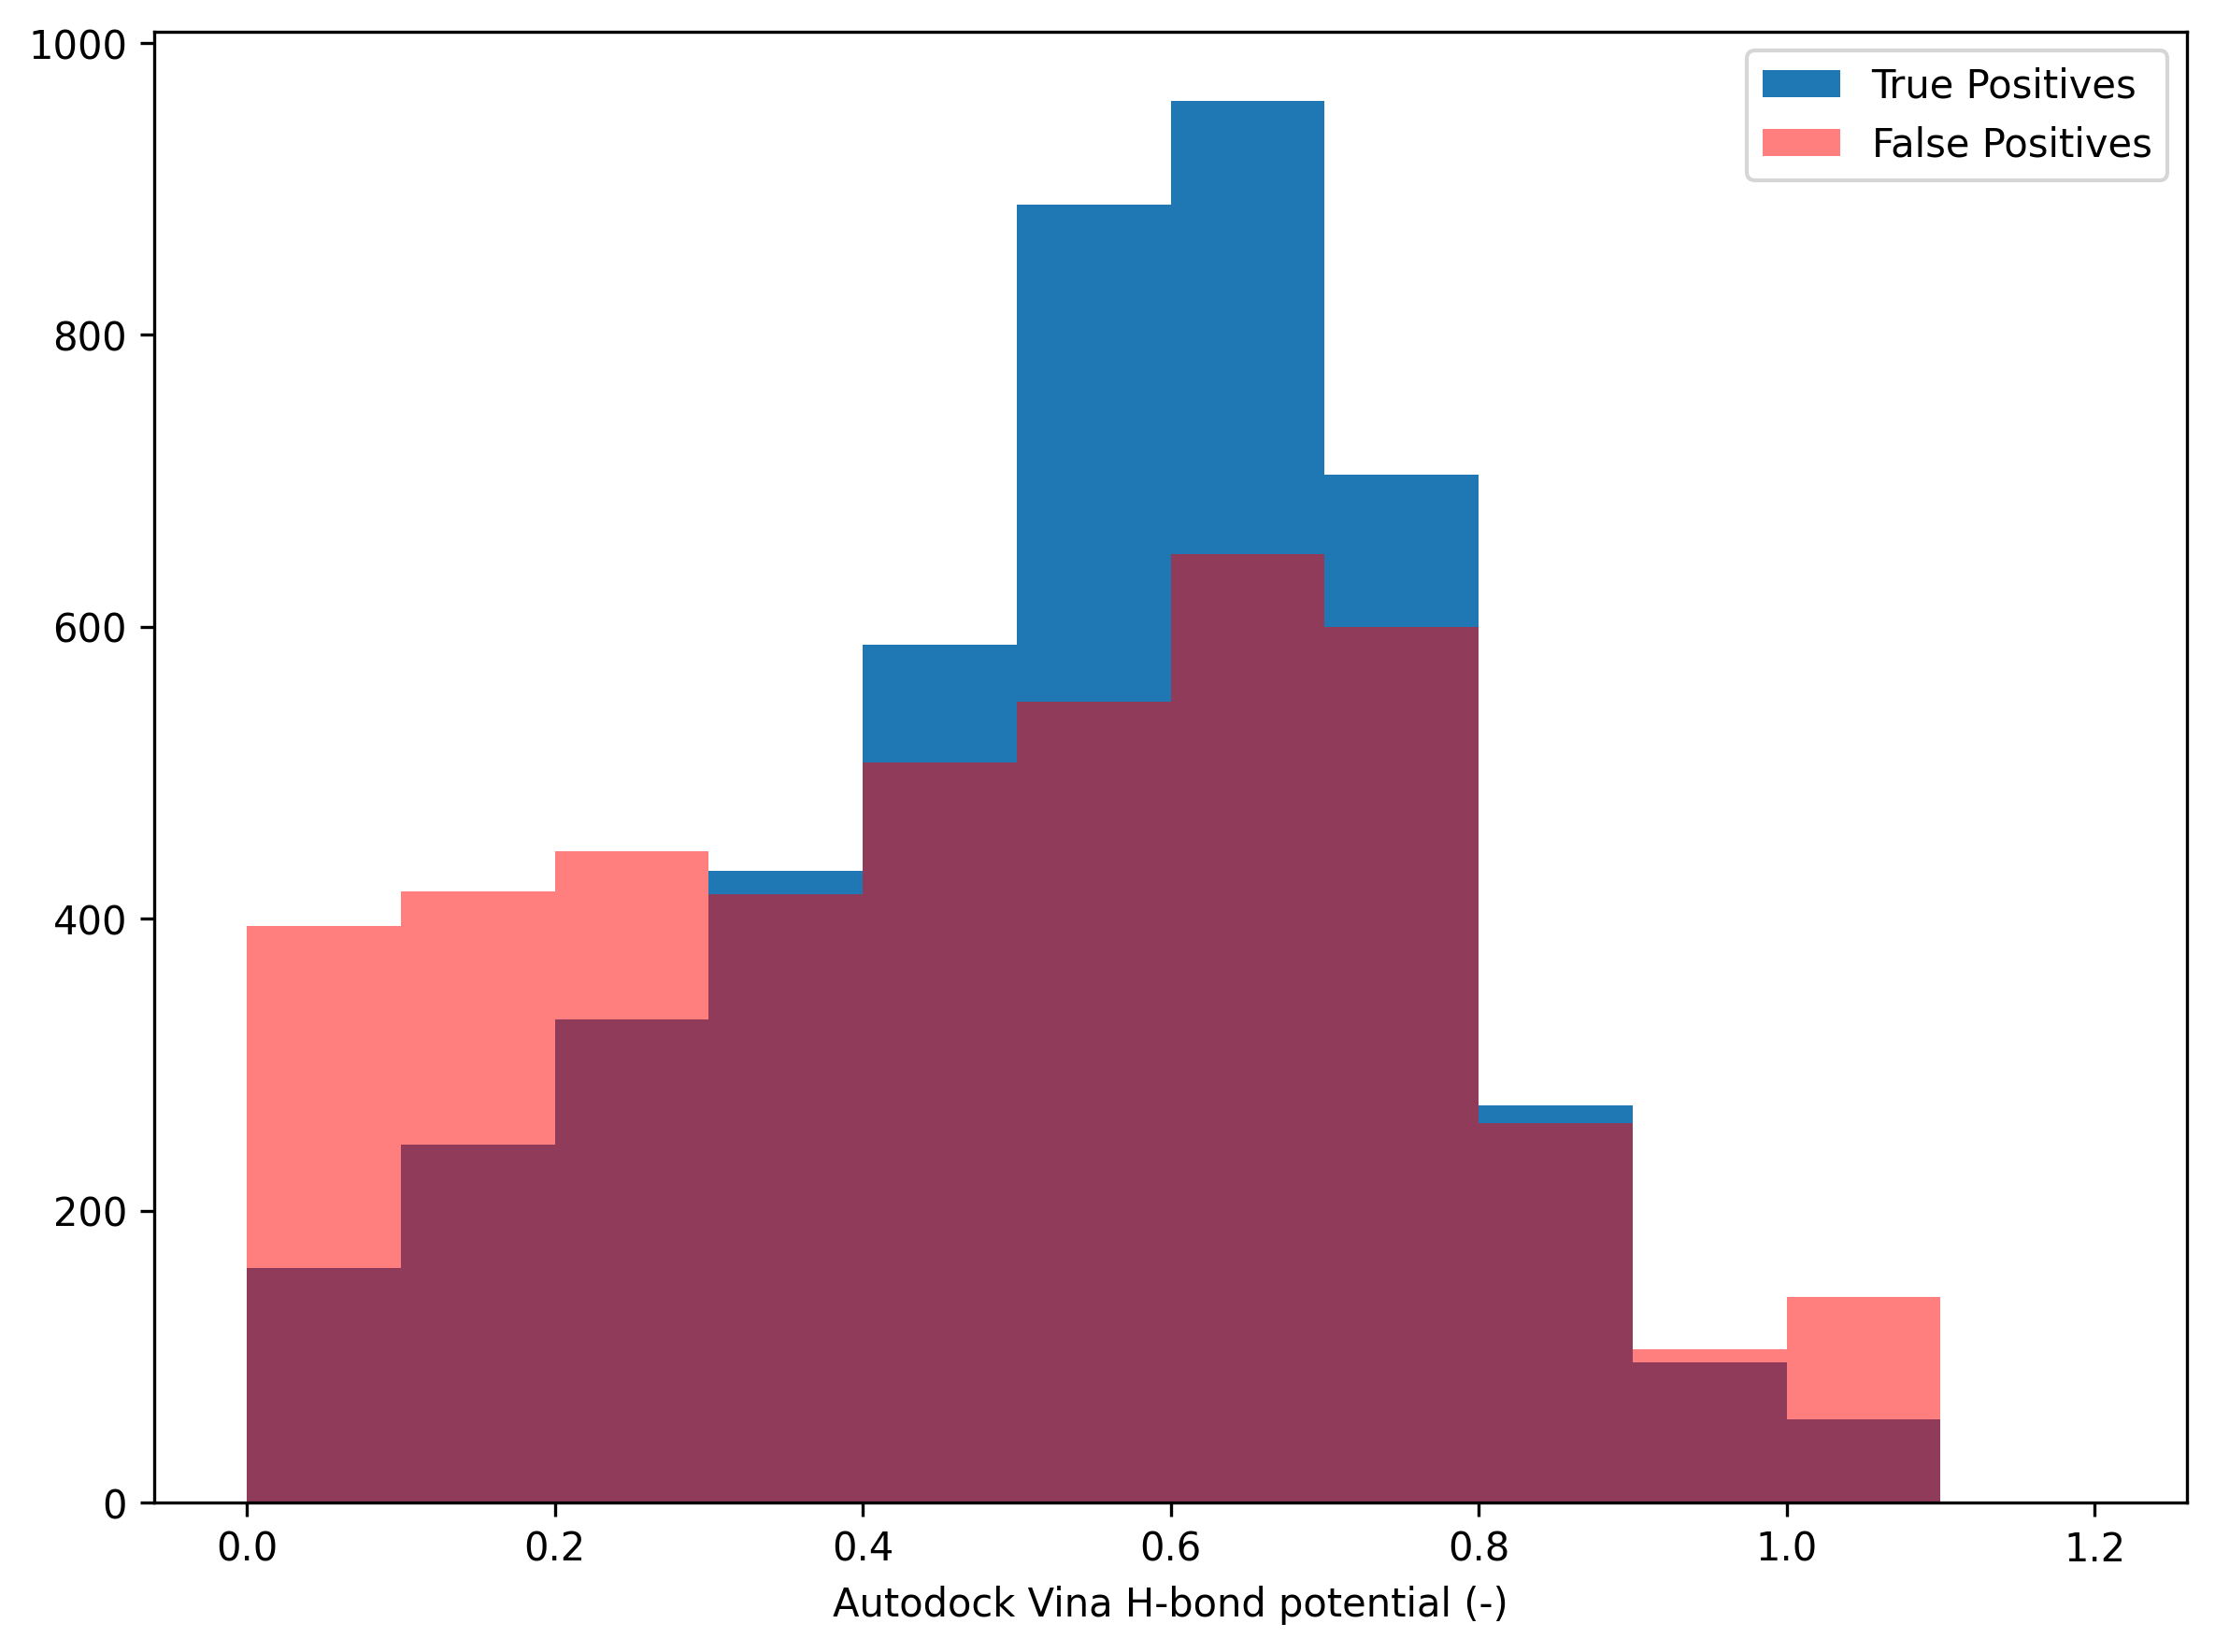

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(1, 1, dpi=300, figsize=(8, 6))

# now determine nice limits by hand:å
binwidth = 0.1
xymax = max(
    np.max(np.abs(all_vhp_list)),
    np.max(np.abs(all_fp_vhp_list)),
)
lim = (int(xymax / binwidth) + 1) * binwidth

bins = np.arange(0, lim + binwidth, binwidth)
ax.hist(all_vhp_list, bins=bins)
ax.hist(all_fp_vhp_list, bins=bins, alpha=0.5, color="red")

ax.set_xlabel("Autodock Vina H-bond potential (-)")
fig.tight_layout()
ax.legend(["True Positives", "False Positives"])
fig.show()